## **Set up**

In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import timeit
import tracemalloc
import seaborn as sns
import random
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [2]:
mat_content = sio.loadmat('assets/face.mat')
# mat_content # Let's see the content...

face_data = mat_content['X']
face_labels = mat_content['l']

x_train, x_test, y_train, y_test = [], [], [], []

n_classes = 52
images_per_class = 10

for i in range(n_classes):
    start_idx = i * images_per_class
    end_idx = start_idx + images_per_class

    x_train.append(face_data[:, start_idx:start_idx+8])
    x_test.append(face_data[:, start_idx+8:end_idx])

    y_train.append(face_labels[:, start_idx:start_idx+8])
    y_test.append(face_labels[:, start_idx+8:end_idx])

x_train, x_test = np.hstack(x_train), np.hstack(x_test)
y_train, y_test = np.hstack(y_train), np.hstack(y_test)

x_train = x_train.astype(np.int64)
x_test = x_test.astype(np.int64)

# Output the shapes of the training and testing sets
print(f"Training set shape: {x_train.shape}")
print(f"Test set shape: {x_test.shape}")

Training set shape: (2576, 416)
Test set shape: (2576, 104)


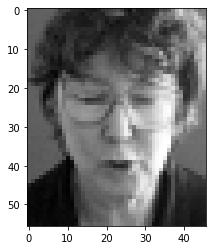

In [3]:
# show one example image
plt.imshow(np.reshape(x_train[:,0],(46,56)).T, cmap = 'gist_gray')

## **Additional Functions**

In [73]:
def draw_confusion_matrix(y_test, y_pred):
    # confusion matrix with 5 base eigenvectors
    cm = confusion_matrix(y_test.reshape(-1), y_pred)

    plt.figure(figsize=(15, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=range(1, 53), yticklabels=range(1, 53))
    plt.title(f'Confusion Matrix of RF')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [85]:
def print_results(accuracy, train_time, test_time, train_peak_memory, test_peak_memory, max_tree_depth):
    print(f"Training Memory Usage (Peak): {train_peak_memory / 10**6:.3f} MB")
    print(f"Training Execution Time: {train_time:.8f} seconds")
    print('\n')

    print(f"Test Memory Usage (Peak): {test_peak_memory / 10**6:.3f} MB")
    print(f"Test Execution Time: {test_time:.6f} seconds")
    print('\n')

    print(f"Maximum depth of trees in the forest: {max_tree_depth}")

    print(f"Accuracy: {accuracy * 100:.2f}%")

In [23]:
def get_suc_fail_cases(y_test, y_pred):
    # Separate success and failure cases
    suc_idx = []
    suc_label = []
    fail_idx = []
    fail_case_prediction_label = []
    fail_case_true_label = []

    for i in range(len(y_pred)):
        if y_test.T[i] == y_pred[i]:
            suc_idx.append(i)
            suc_label.append(int(y_test.T[i]))
        else:
            fail_idx.append(i)
            # fail as which image
            fail_case_prediction_label.append(int(y_pred.T[i]))
            fail_case_true_label.append(int(y_test.T[i]))

    return suc_idx, suc_label, fail_idx, fail_case_prediction_label, fail_case_true_label

In [7]:
def RF_classification(x_train, y_train, x_test, y_test, n_estimators=100, max_depth=1000, bootstrap=True, random_state=0, max_samples=0.8, max_features="sqrt", criterion='entropy', time_memory_check=False):
    rf_clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, bootstrap=bootstrap, random_state=random_state, max_samples=max_samples, max_features=max_features, criterion=criterion)

    # Train ----------------------------------------------------------
    tracemalloc.start() 
    start_time = timeit.default_timer() 
    
    rf_clf.fit(x_train.T, y_train.ravel())
    
    train_time = timeit.default_timer() - start_time
    current, train_peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    # Test ----------------------------------------------------------
    tracemalloc.start() 
    start_time = timeit.default_timer()

    y_pred = rf_clf.predict(x_test.T)

    test_time = timeit.default_timer()- start_time
    current, test_peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    accuracy = accuracy_score(y_test.T, y_pred)

    # Full classification report
    # print(classification_report(y_test.T, y_pred, zero_division=0))

    # Retrieve the maximum depth of each tree in the forest
    tree_depths = [estimator.tree_.max_depth for estimator in rf_clf.estimators_]
    max_tree_depth = max(tree_depths)

    return accuracy, y_pred, train_time, test_time, train_peak_memory, test_peak_memory, max_tree_depth

In [8]:
def create_two_pixel_features(x_train, x_test, n_pairs=None, random_seed=None):
    x_combined = np.concatenate([x_train, x_test], axis=1)

    n_features, n_samples = x_combined.shape

    # Set random seed if provided
    if random_seed is not None:
        random.seed(random_seed)

    # Generate all unique pairs of features where i != j
    feature_pairs = [(i, j) for i in range(n_features) for j in range(i + 1, n_features)]

    # If n_pairs is specified, randomly select a subset of feature pairs
    if n_pairs is not None and n_pairs < len(feature_pairs):
        feature_pairs = random.sample(feature_pairs, n_pairs)
    
    # Initialize a new features matrix for pairwise differences
    new_features = np.zeros((len(feature_pairs), n_samples))

    # Fill in the new features with pairwise differences
    for idx, (i, j) in enumerate(feature_pairs):
        new_features[idx, :] = x_combined[i, :] - x_combined[j, :]

    x_train_2pix = new_features[:, :x_train.shape[1]]
    x_test_2pix = new_features[:, x_train.shape[1]:]

    return x_train_2pix, x_test_2pix

In [9]:
def avg_results(num_iter, x_train, y_train, x_test, y_test, n_estimators=5, max_depth=15, bootstrap=True, random_state=0, max_samples=0.7, max_features="sqrt", criterion='entropy'):
    results_array = np.zeros((6,))
    
    for i in range(num_iter):
        accuracy, y_pred, train_time, test_time, train_peak_memory, test_peak_memory, max_tree_depth = RF_classification(x_train, y_train, x_test, y_test, n_estimators=n_estimators, max_depth=max_depth, bootstrap=bootstrap, random_state=random_state, max_samples=max_samples, max_features=max_features, criterion=criterion)
        results_array += np.array([accuracy, train_time, test_time, train_peak_memory, test_peak_memory, max_tree_depth])

    results_array /= num_iter
    return results_array

In [70]:
def show_suc_fail_histogram(suc_label, fail_case_true_label):
    # Show success cases ------------------------------------------------
    bins = 52

    # Plotting the histograms
    plt.figure(figsize=(15, 6))
    plt.hist(suc_label, bins=bins, label='Success', color='b')
    plt.xlabel('True Label')
    plt.ylabel('Count Cases')
    plt.title('Histogram of Success Cases')
    plt.legend()
    plt.xlim(left=1, right=52)

    plt.xticks([i for i in range(1, 53)])
    plt.yticks([1, 2])

    plt.show()

    # Show failure cases ------------------------------------------------
    bins = 52

    # Plotting the histograms
    plt.figure(figsize=(15, 6))
    plt.hist(fail_case_true_label, bins=bins, label='Failure', color='r')
    plt.xlabel('True Label')
    plt.ylabel('Count Cases')
    plt.title('Histogram of Failure Cases')
    plt.legend()
    plt.xlim(left=1, right=52)

    plt.xticks([i for i in range(1, 53)])
    plt.yticks([1, 2])

    plt.show()

## **Q5. RF classifier**

### Weak learner: Axis-aligend test

Training Memory Usage (Peak): 4.421 MB
Training Execution Time: 0.91204438 seconds


Test Memory Usage (Peak): 1.216 MB
Test Execution Time: 0.00837837 seconds


Maximum depth of trees in the forest: 10
Accuracy: 75.96%


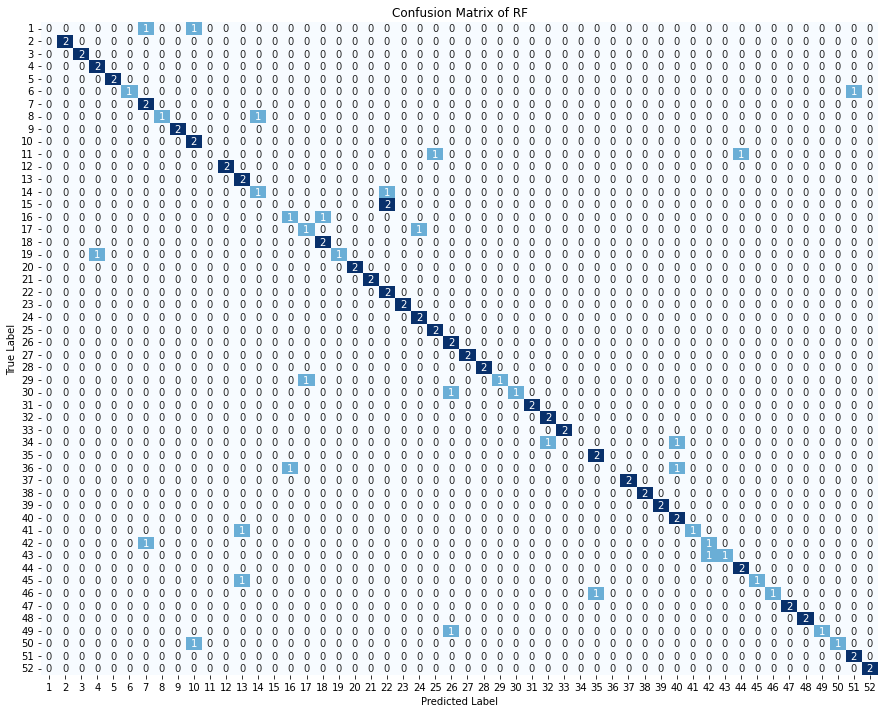

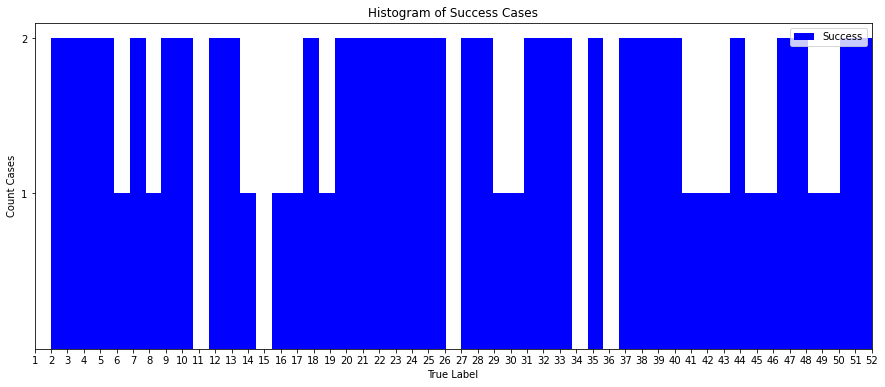

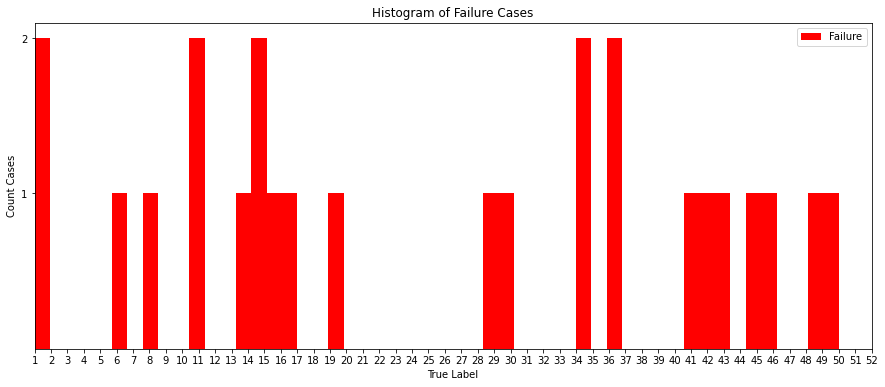

In [ ]:
# default_setting
x_train, y_train, x_test, y_test, n_estimators=30, max_depth=15, bootstrap=True, random_state=0, max_samples=0.7, max_features="sqrt", criterion='entropy', time_memory_check=True

# Get results
accuracy, y_pred, train_time, test_time, train_peak_memory, test_peak_memory, max_tree_depth = RF_classification(x_train, y_train, x_test, y_test, n_estimators=30, max_depth=15, bootstrap=True, random_state=0, max_samples=0.7, max_features="sqrt", criterion='entropy', time_memory_check=True)

# Print results
print_results(accuracy, train_time, test_time, train_peak_memory, test_peak_memory, max_tree_depth)

# Draw confusion matrix
draw_confusion_matrix(y_test, y_pred)

# Get success and failure examples
suc_idx, suc_label, fail_idx, fail_case_prediction_label, fail_case_true_label = get_suc_fail_cases(y_test, y_pred)

# Show success case and failure cases histogram
show_suc_fail_histogram(suc_label, fail_case_true_label)

### Weak learner: Two-Pixel Test

Training Memory Usage (Peak): 4.419 MB
Training Execution Time: 1.00822687 seconds


Test Memory Usage (Peak): 1.216 MB
Test Execution Time: 0.00900562 seconds


Maximum depth of trees in the forest: 10
Accuracy: 74.04%


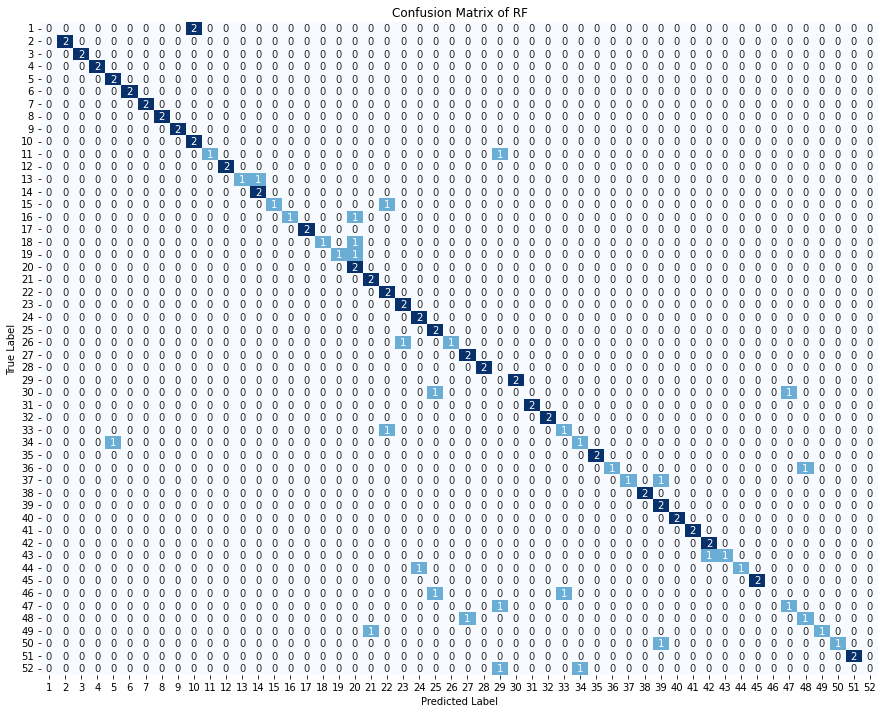

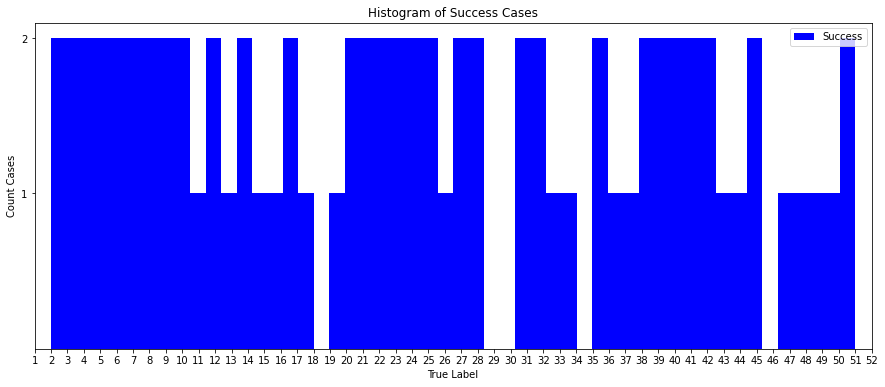

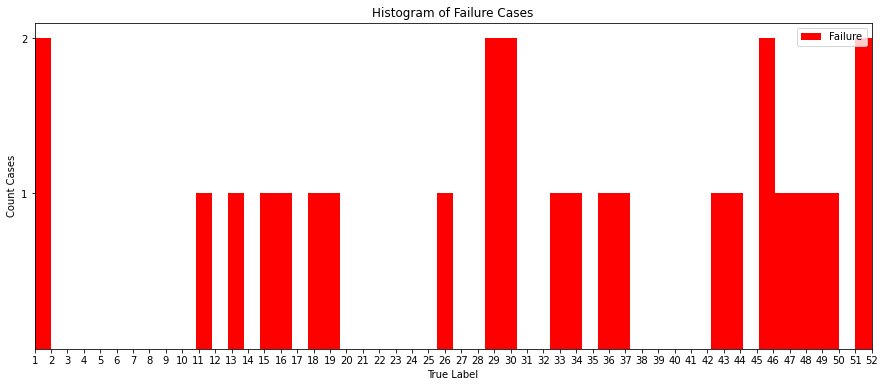

In [77]:
x_train_2pix, x_test_2pix = create_two_pixel_features(x_train, x_test, n_pairs=2576, random_seed=0)

# Get results
accuracy, y_pred, train_time, test_time, train_peak_memory, test_peak_memory, max_tree_depth = RF_classification(x_train_2pix, y_train, x_test_2pix, y_test, n_estimators=30, max_depth=15, bootstrap=True, random_state=0, max_samples=0.7, max_features="sqrt", criterion='entropy', time_memory_check=True)

# Print results
print_results(accuracy, train_time, test_time, train_peak_memory, test_peak_memory, max_tree_depth)

# Draw confusion matrix
draw_confusion_matrix(y_test, y_pred)

# Get success and failure examples
suc_idx, suc_label, fail_idx, fail_case_prediction_label, fail_case_true_label = get_suc_fail_cases(y_test, y_pred)

# Show success case and failure cases histogram
show_suc_fail_histogram(suc_label, fail_case_true_label)

### Average result

In [91]:
# average result of two-pixel test
num_iter = 10

results_array = avg_results(num_iter, x_train, y_train, x_test, y_test, n_estimators=5, max_depth=15, bootstrap=True, random_state=0, max_samples=0.7, max_features="sqrt", criterion='entropy')

print(f'average results with {num_iter} iterations')
print_results(results_array[0], results_array[1], results_array[2], results_array[3], results_array[4], results_array[5])

average results with 10 iterations
Training Memory Usage (Peak): 4.419 MB
Training Execution Time: 0.16428766 seconds


Test Memory Usage (Peak): 1.212 MB
Test Execution Time: 0.00219765 seconds


Maximum depth of trees in the forest: 9.0
Accuracy: 33.65%


### Hyperparameter Tuning

In [84]:
# Hyperparameter tuning
def RF_random_search(x_train, y_train, x_test, y_test, n_iter, cv, random_state=None):
    # Search settings
    rf_clf = RandomForestClassifier(n_estimators=50, bootstrap=True, random_state=random_state)

    param_distributions = dict()
    param_distributions['n_estimators'] = [10*i for i in range(20, 30)]
    # param_distributions['max_depth'] = [i for i in range(5,21)]
    param_distributions['max_samples'] = [0.1 * i for i in range(1,11)]
    param_distributions['max_features'] = ['sqrt', 'log2']
    param_distributions['criterion'] = ["gini", "entropy"]
    
    random_search = RandomizedSearchCV(rf_clf, param_distributions, n_iter=n_iter, scoring='accuracy', cv=cv, n_jobs=-1)
    random_result = random_search.fit(x_train.T, y_train.ravel())

    print(f'Best Parameters: {random_search.best_params_}')
    print(f'Best Accuracy: {random_result.best_score_}')

    best_rf = random_search.best_estimator_

    y_pred = best_rf.predict(x_test.T)
    accuracy = accuracy_score(y_test.T, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    return random_search.best_estimator_

best_rf = RF_random_search(x_train, y_train, x_test, y_test, n_iter=30, cv=5, random_state=0)

Best Parameters: {'n_estimators': 270, 'max_samples': 0.9, 'max_features': 'log2', 'criterion': 'entropy'}
Best Accuracy: 0.620453241537579
Accuracy: 85.58%
